In [6]:
pkg load image
pkg load signal

In [7]:
function Q = quantization(n)
    %This function gives the quantization, 8x8 matrix for a given n
    %n -> Level of quantization, it is a integer between 0 and 100
    Q50=[16 11 10 16 24 40 51 61;
         12 12 14 19 26 58 60 55;
         14 13 16 24 40 57 59 56;
         14 17 22 29 51 87 80 62;
         18 22 37 56 68 109 103 77;
         24 35 55 64 81 104 113 92;
         49 64 78 87 103 121 120 101;
         72 92 95 98 112 100 103 99];
    if n == 50
        Q = Q50;
    elseif n == 0
        Q = ones(8, 8);
    elseif and(n > 50, n < 100)
        Q = round(((100 - n) / 50) * Q50);
    elseif and(n > 0, n < 50)
        Q = round((50/n)*Q50);
    else
        Q = NaN;
        display("N debe estar entre 0 y. 100");
    endif
endfunction

In [8]:
quantization(0)

ans =

   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1



In [9]:
quantization(99)

ans =

   0   0   0   0   0   1   1   1
   0   0   0   0   1   1   1   1
   0   0   0   0   1   1   1   1
   0   0   0   1   1   2   2   1
   0   0   1   1   1   2   2   2
   0   1   1   1   2   2   2   2
   1   1   2   2   2   2   2   2
   1   2   2   2   2   2   2   2



In [10]:
quantization(1)

ans =

    800    550    500    800   1200   2000   2550   3050
    600    600    700    950   1300   2900   3000   2750
    700    650    800   1200   2000   2850   2950   2800
    700    850   1100   1450   2550   4350   4000   3100
    900   1100   1850   2800   3400   5450   5150   3850
   1200   1750   2750   3200   4050   5200   5650   4600
   2450   3200   3900   4350   5150   6050   6000   5050
   3600   4600   4750   4900   5600   5000   5150   4950



In [11]:
function x = zigzag(A)
    %This function encodes the matrix A into a vextor using the zigzag method
    %A -> matrix
    [m,~]=size(A);
    n = floor((2*m-1)/2);
    diags = [flip(-n:n)];
    s = sum(abs(A)(:));
    x = [];
    for d = diags
        c = m - abs(d);
        if (d>=0) i = c; j = 1; endif    
        if (d<0) i = m; j = abs(d)+1; endif

        diag = [];
        for e = 1:c
            diag = [diag A(i,j)];
            i-=1; j+=1;      
        endfor

        if mod(abs(d),2) == 0 % Es una diagonal par

            x = [x flip(diag)];
        else 
            x = [x diag]; 
        endif  

        s1 = sum(abs(x));
        if s1 == s
            break;      
        endif
    endfor
endfunction

In [26]:
function A = izigzag(x,m)
    %This function encodes a vector x into a matrix using the inverse zigzag method
    %x -> zigzzag encoded vector
    %m -> size of the final matrix (mxm)
    n = floor((2*m-1)/2); 
    diags = [flip(-n:n)];
    s = sum(abs(x));
    A = zeros(m);
    l = 1; 
    for d = diags
        c = m - abs(d); 
        if (d>=0) i = c; j = 1; endif    
        if (d<0) i = m; j = abs(d)+1; endif

        elementos = x(l:l+c-1); 

        if mod(abs(d),2) == 0
            elementos = flip(elementos);
        endif

        for e = 1:c
            A(i,j) = elementos(e);
            i-=1; j+=1;      
        endfor

        l = l+c; 

        s1 = sum(abs(A)(:));
        if s1 == s
            break;      
        endif
    endfor
endfunction

In [20]:
function compressed_image = jpeg_compression(image, n_l)
    %This function compresses an image into a cell using the JPEG method
    %image -> matrix representing the image
    %n_l -> level of compression of the image
    %compressed_image -> cell representing the 8x8 blocks
    [m,n] = size(image);
    m = fix(m/8); 
    n = fix(n/8);
    compressed_image = cell(m,n);
    for i = 1:m
        i_end = 8*i;
        i_start = i_end - 7;
        for j = 1:n
            j_end = 8*j;
            j_start = j_end - 7;
            
            kernel = image(i_start:i_end, j_start:j_end);
            reduced_image = kernel - 128;
            dct_image = dct2(reduced_image);
            Q = quantization(n_l);
            quantized_image = round(dct_image ./ Q);
            vect = zigzag(quantized_image);
            
            compressed_image(i, j) = vect;
        endfor
    endfor
endfunction

In [28]:
function decompressed_image = jpeg_decompression(compressed_image, n_l)
    %This function decompresses an image into a cell using the JPEG method
    %image -> cell representing the 8x8 blocks of the compressed image
    %n_l -> level of compression of the image
    %decompressed_image -> matrix representing the image
    [m , n] = size(compressed_image);
    decompressed_image = zeros(m*8, n*8);
    for i= 1:m
        i_end = 8*i;
        i_start = i_end - 7;
        for j = 1:n
            j_end = 8*j;
            j_start = j_end - 7;
            
            kernel = compressed_image{i , j};
            inverse_zigzag = izigzag(kernel, 8);
            Q =  quantization(n_l);
            kernel_image = Q .* inverse_zigzag;
            
            rounded_kernel = round(idct2(kernel_image));
            rounded_kernel = rounded_kernel + 128;
            decompressed_image(i_start:i_end, j_start:j_end) = rounded_kernel;
        endfor
    endfor
endfunction

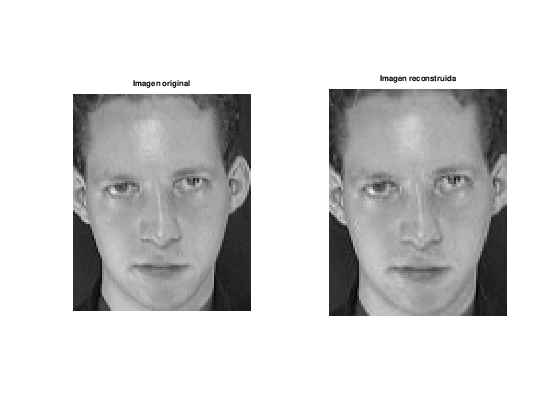

In [34]:
A = imread('../Imagenes/1_3.png');
A = double(A);
B = jpeg_compression(A, 75);

Ar = jpeg_decompression(B, 75);
Ar = uint8(Ar);

subplot(1,2,1);
imshow(uint8(A));
title('Imagen original');

subplot(1,2,2);
imshow(Ar);
title('Imagen reconstruida');
